Maxwell's equations
For simplicity, we start with the very basic example from
https://www.math.colostate.edu/~bangerth/videos.676.33.html
Specifically,
$$
\int_\Omega \left[\mathrm{curl}(\boldsymbol{\delta u}) \cdot \mathrm{curl}(\boldsymbol{u})
+ \mathrm{div}(\boldsymbol{\delta u}) \mathrm{div}(\boldsymbol{u})\right] \mathrm{d}\Omega = 0
$$
As noted in the lecture, standard Lagrange elements are not sufficient to solve this problem accurately,
and we therefore use the Nedelec interpolation.

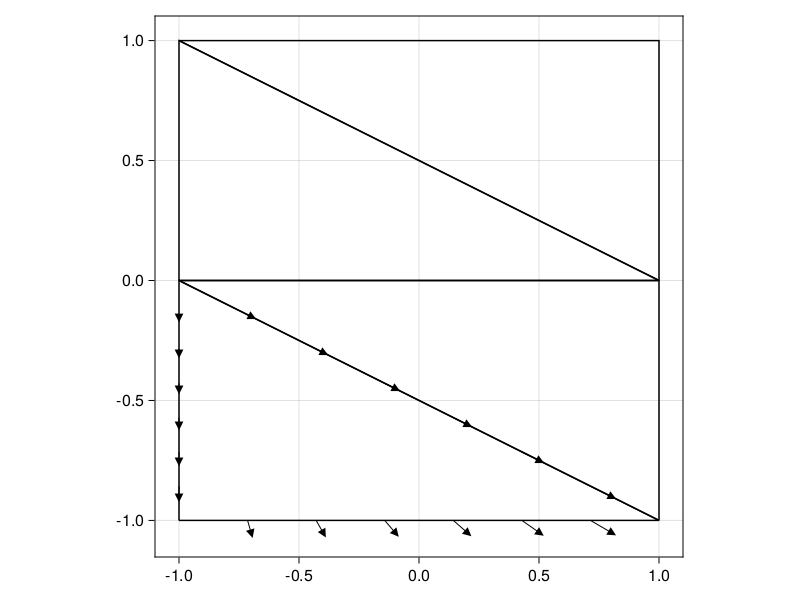

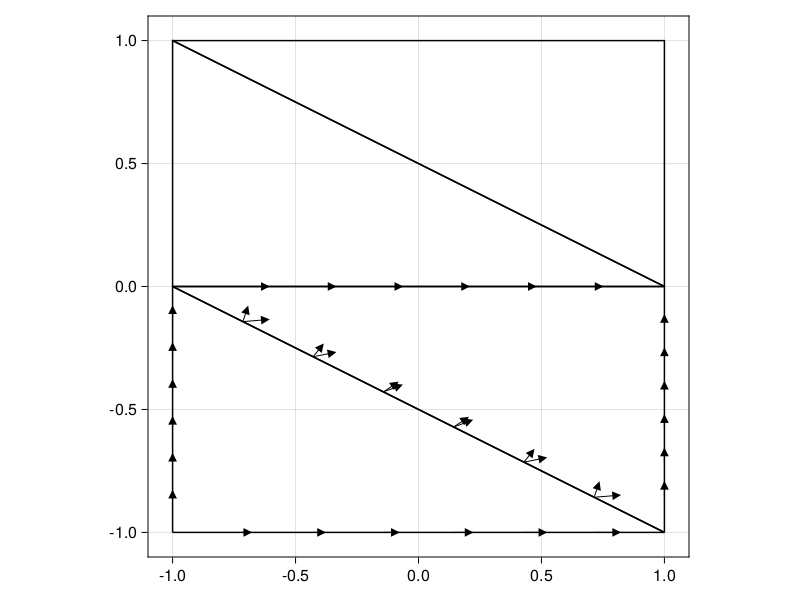

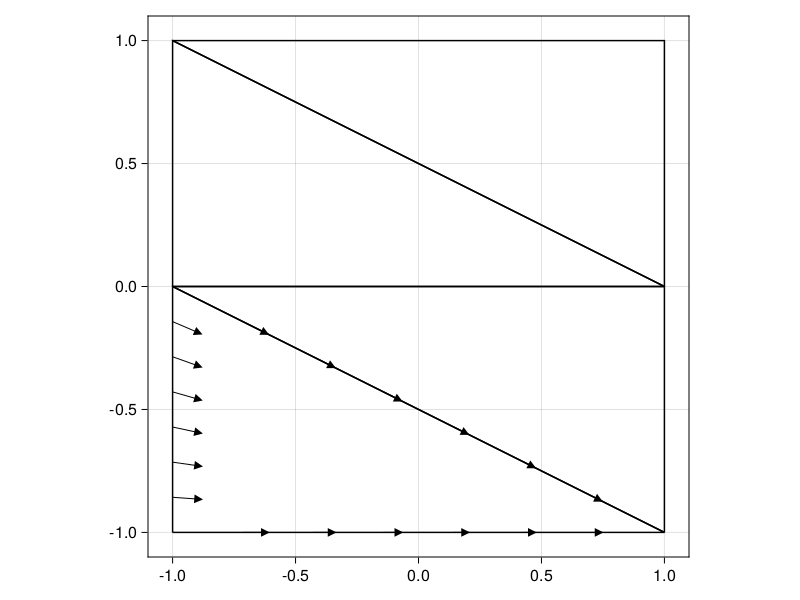

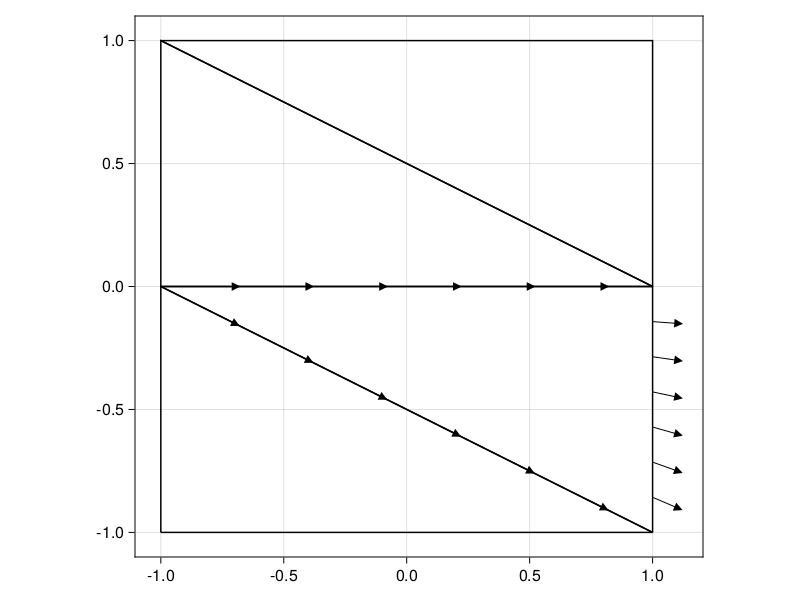

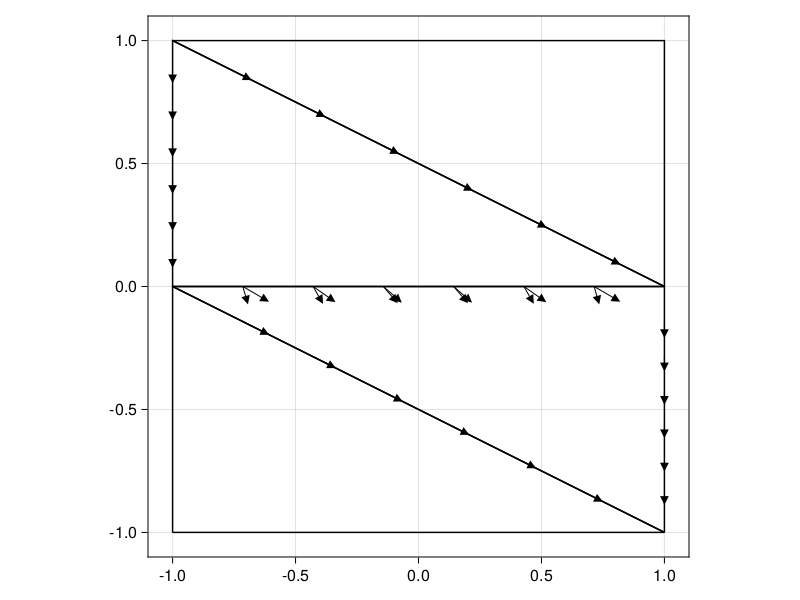

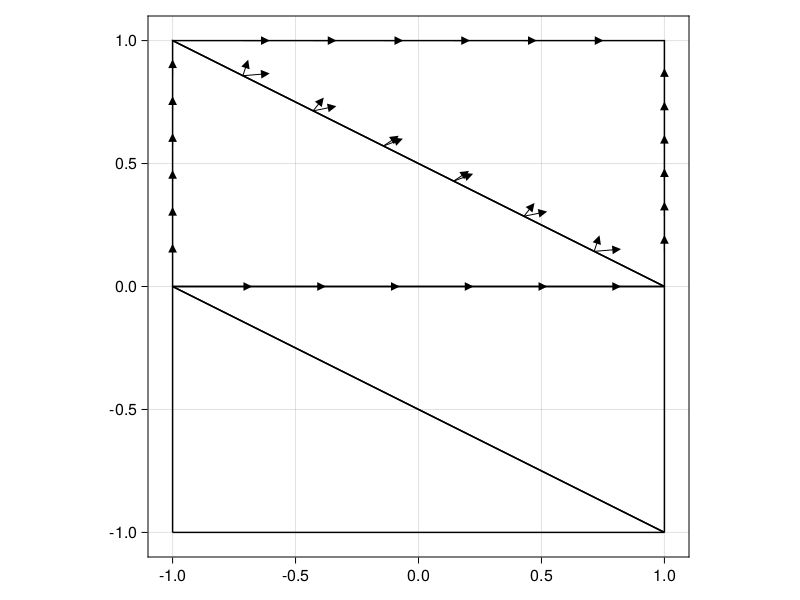

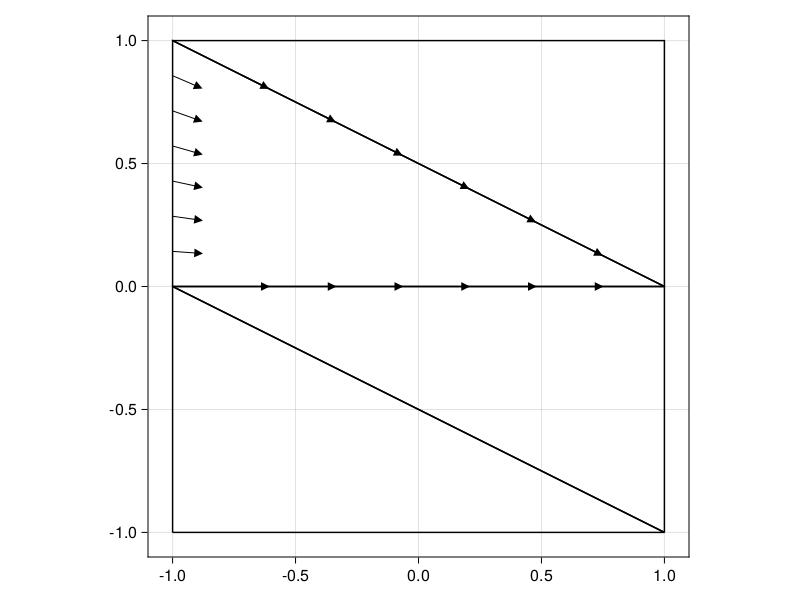

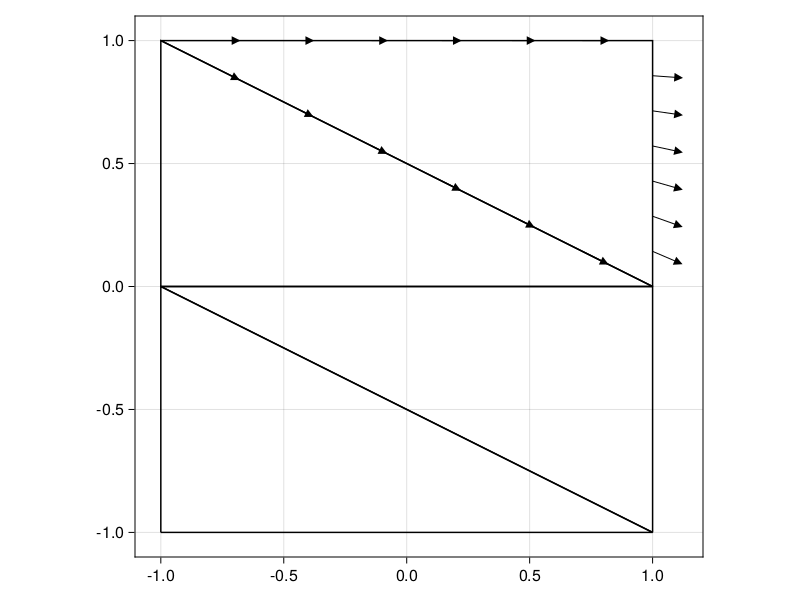

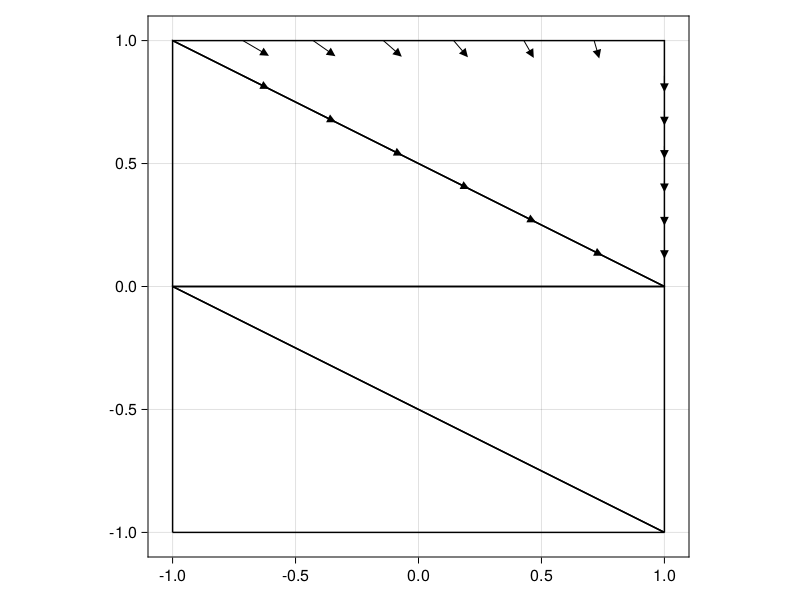

In [1]:
import LinearAlgebra: normalize
using StaticArrays
using Test
using Ferrite
import Ferrite: Nedelec, RaviartThomas
import CairoMakie as M
ip = Nedelec{2,RefTriangle,2}()
ip = RaviartThomas{2,RefTriangle,1}()
grid = generate_grid(Triangle, (1,2))
dh = DofHandler(grid)
add!(dh, :B, ip)
close!(dh)

ip_geo = Ferrite.default_interpolation(Triangle)
qr = QuadratureRule{RefTriangle}(10)

qr_points = Vec{2,Float64}[]; n=6
append!(qr_points, [Vec((0.0, i/(n+1))) for i in 1:n])
append!(qr_points, [Vec((i/(n+1), 0.0)) for i in 1:n])
append!(qr_points, [Vec((i/(n+1), 1 - i/(n+1))) for i in 1:n])
qr = QuadratureRule{RefTriangle}(zeros(length(qr_points)), qr_points)
cv = CellValues(qr, ip, ip_geo)

function plot_shapes(dh, cv)
    grid = dh.grid
    n_qp = getncells(grid)*getnquadpoints(cv)
    coords = (zeros(n_qp), zeros(n_qp))
    vectors = (zeros(n_qp), zeros(n_qp))

    for nr in 1:(ndofs(dh))
        u = zeros(ndofs(dh))
        u[nr] = 1.0

        for cell_nr in 1:getncells(grid)
            x = getcoordinates(grid, cell_nr)
            reinit!(cv, x, getcells(grid, cell_nr))
            ue = u[celldofs(dh, cell_nr)]
            for q_point in 1:getnquadpoints(cv)
                i = getnquadpoints(cv)*(cell_nr-1) + q_point
                qp_x = spatial_coordinate(cv, q_point, x)
                v = function_value(cv, q_point, ue)
                sfac = norm(v) ≈ 0 ? NaN : 1.0 # Skip plotting zero-vector points
                coords[1][i] = sfac*qp_x[1]
                coords[2][i] = sfac*qp_x[2]
                vectors[1][i] = v[1]
                vectors[2][i] = v[2]
            end
        end

        fig = M.Figure()
        ax = M.Axis(fig[1,1]; aspect=M.DataAspect())
        for cellnr in 1:getncells(grid)
            x = getcoordinates(grid, cellnr)
            push!(x, x[1])
            M.lines!(ax, first.(x), last.(x), color=:black)
        end
        M.arrows!(ax, coords..., vectors...; lengthscale=0.1)
        display(fig)
    end
    return nothing
end
plot_shapes(dh, cv)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*